<a href="https://colab.research.google.com/github/hereagain-Y/TF_tutorial/blob/main/VAE_add_plotandreconstruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from six.moves import xrange
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

Load CDR3 Data

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
s = []
my_file = open("/content/drive/My Drive/DL/VAE/NormalCDR3.txt", "r")
content_list = my_file.read().splitlines()
content_list=np.array(content_list)
print(content_list)


['CASSLKPNTEAFF' 'CASSAHIANYGYTF' 'CASSPRPNTEAFF' ... 'CASSVDVGYEQYF'
 'CASRLAGQETQYF' 'CASSVVPNTEAFF']


Load AA index data

In [67]:
d= {} # bipphysics dictionary
with open("/content/drive/My Drive/DL/VAE/AAidx_PCA.txt") as f:
    next(f)
    for line in f.readlines():
        line=line.strip().split('\t') #
        AA=line[0]
        tag=0
        values=[]
        for PC in line[1:]:
            values.append(float(PC))
        if tag==1: 
            continue
        d[AA]=values
 # AA


# normalization 

In [6]:
max(d['A'])
type(d['A'])

list

In [68]:
 
 #return 0 -1 (xi – min(x)) / (max(x) – min(x))

def normalize(d):
  result = {}
  for key, value in d.items():
    maxval = max(d[key])
    minval = min(d[key])
    newval=[]
    for number in value:

      newval.append((number-minval)/(maxval-minval))
    
    result[key] =newval
  return(result)
    



In [69]:

d_norm=normalize(d)
d_norm

{'A': [0.07525231330089575,
  0.11110993247250554,
  1.0,
  0.10085171430385075,
  0.3362586030378956,
  0.08589557098930195,
  0.3166716257763159,
  0.07845695355133557,
  0.29558950944630463,
  0.0,
  0.17264524667274148,
  0.02519795885608285,
  0.21399362066317887,
  0.20352855444366297,
  0.315091708147771],
 'C': [0.0,
  0.7495696809258403,
  0.07865597242639141,
  1.0,
  0.7627030301724574,
  0.8168259804237982,
  0.4333259554067372,
  0.16777058828085453,
  0.33203232126086285,
  0.5724424696175718,
  0.4816359939467978,
  0.39170914029908754,
  0.4294503690415155,
  0.37686420256824266,
  0.3449489815613006],
 'D': [1.0,
  0.25640988772162693,
  0.32592183369372396,
  0.4200305281353341,
  0.5744582792254195,
  0.1560420670881465,
  0.0,
  0.3091207506859722,
  0.258039340323857,
  0.2882727977487466,
  0.3895335207450628,
  0.38763175831637187,
  0.18676139620557258,
  0.5451097643479257,
  0.2696370438467982],
 'E': [1.0,
  0.0,
  0.8519057393700852,
  0.4383574918534277,
  

In [70]:
# max length
#comp_seq=data["amino_acid"].tolist()

comp_seq=content_list
print(comp_seq)
max_len=-1 

for AA in comp_seq:
    if len(AA)>max_len:
        max_len=len(AA)
        #res=AA
print(max_len )

['CASSLKPNTEAFF' 'CASSAHIANYGYTF' 'CASSPRPNTEAFF' ... 'CASSVDVGYEQYF'
 'CASRLAGQETQYF' 'CASSVVPNTEAFF']
19


In [71]:
PC_length=len(d_norm['C'])
def AAindexEncoding(Seq):
    length_seq=len(Seq)
    global max_len
    AAE=np.zeros([max_len,15])
    if length_seq<max_len:
        for amino in range(length_seq):
            AA=Seq[amino]# 
            AAE[amino,]=d_norm[AA] # add PC value 
            
        for amino in range(length_seq,max_len):
            AAE[amino,]=np.zeros(15)
    else: 
        for amino in range(length_seq): # zero padding
            AA=Seq[amino]# 
            AAE[amino,]=d_norm[AA]
        
    #AAE=np.transpose(AAE.astype(np.float32)) # row as PC. and column as AA sequence 
    return AAE 
  
def GetFeatures(file):
    #sequence=file['amino_acid'].tolist()
    #sequence=np.array(sequence)
    #sequence = file.read().splitlines()
    #sequence=np.array(sequence)
    hot_encode=[]
    for seq in file:
        hot_encode.append(AAindexEncoding(seq))
    hot_encode=np.array(hot_encode)
    result=np.array(hot_encode)
    return(result) # dimension: number of sequence [15*length(sequence)]


r1=GetFeatures(content_list)

In [9]:
r1

array([[[0.        , 0.74956968, 0.07865597, ..., 0.42945037,
         0.3768642 , 0.34494898],
        [0.07525231, 0.11110993, 1.        , ..., 0.21399362,
         0.20352855, 0.31509171],
        [1.        , 0.66292414, 0.39714219, ..., 0.28816463,
         0.27269622, 0.27479255],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.74956968, 0.07865597, ..., 0.42945037,
         0.3768642 , 0.34494898],
        [0.07525231, 0.11110993, 1.        , ..., 0.21399362,
         0.20352855, 0.31509171],
        [1.        , 0.66292414, 0.39714219, ..., 0.28816463,
         0.27269622, 0.27479255],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [72]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [73]:
# transform 
kwargs = {'num_workers': 1, 'pin_memory': True} 
r1_transform=torch.from_numpy(r1) # from np to tensor
r1_transform=r1_transform.float()
r1_transform.shape
#r1_mean = torch.mean(r1_transform)
#r1_std = torch.std(r1_transform)
#r1_var =  torch.var(r1_transform)
#print("mean, std, var of tensor:\n", r1_mean, r1_std, r1_var)

# normalization 
#r1_transform = (r1_transform-r1_mean)/r1_var
#train_ds, test_ds = torch.utils.data.random_split(r2_transform, (30000, 10000))
train_ds, test_ds =torch.utils.data.random_split(r1_transform, (int(0.8*len(r1_transform)), len(r1_transform)-int(0.8*len(r1_transform))))
print(train_ds, test_ds)

train_loader = DataLoader(dataset=train_ds, batch_size=1000)
test_loader  = DataLoader(dataset=test_ds,  batch_size=1000)



<torch.utils.data.dataset.Subset object at 0x7f5ebe45aa90> <torch.utils.data.dataset.Subset object at 0x7f5ebe45ab50>


In [74]:
# set paramters:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 1000

x_dim=285 # 19*15
hidden_dim = 128
#hidden_dim2 = 

latent_dim = 32

lr = 1e-3

epochs = 200

In [75]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_input3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
       # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        
        self.training = True
        
    def forward(self, x):
        h_       = self.relu(self.FC_input(x))
        h_       = self.relu(self.FC_input2(h_))
        h_       = self.relu(self.FC_input3(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                     #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [76]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim,output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h     = self.relu(self.FC_hidden(x))
        h     = self.relu(self.FC_hidden3(h))
        h     = self.relu(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        
        #x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [77]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var) ]
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [78]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim,  latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [79]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    #reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # try MSE 
    MSELoss_criterion = nn.MSELoss()
    reproduction_loss = MSELoss_criterion(x_hat, x) 
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [21]:
print(enumerate(train_loader))

	Epoch 0 complete! 	Average Loss:  0.0377890128493309 	Average Test Loss:  0.0004937094705445426
	Epoch 10 complete! 	Average Loss:  0.0002914165412741048 	Average Test Loss:  7.196110912731715e-05
	Epoch 20 complete! 	Average Loss:  0.00025915794926030294 	Average Test Loss:  6.448617417897497e-05
	Epoch 30 complete! 	Average Loss:  0.00024978795647621156 	Average Test Loss:  6.217781560761588e-05
	Epoch 40 complete! 	Average Loss:  0.0002455496591116701 	Average Test Loss:  6.115901576621192e-05
	Epoch 50 complete! 	Average Loss:  0.00024367054126092367 	Average Test Loss:  6.0625953865902764e-05
	Epoch 60 complete! 	Average Loss:  0.00024211209480251586 	Average Test Loss:  6.07045479118824e-05
	Epoch 70 complete! 	Average Loss:  0.00024244349662746702 	Average Test Loss:  6.251084165913718e-05
	Epoch 80 complete! 	Average Loss:  0.00024032244352357727 	Average Test Loss:  5.994817774210657e-05
	Epoch 90 complete! 	Average Loss:  0.0002406213783792087 	Average Test Loss:  6.12911166

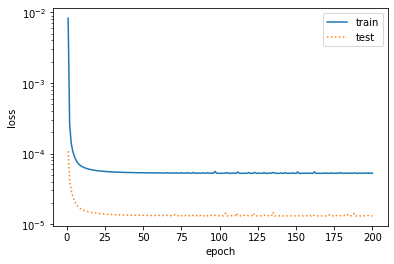

In [80]:
def plotCurve(x_vals,y_vals,x_label, y_label,
              x2_vals=None, y2_vals=None, legend=None,figsize=(3.5,2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
    
    if legend:
        plt.legend(legend)
    

train_loss= [] # before epoch
testtoal_loss= []
for epoch in range(epochs):
    overall_loss = 0
    overall_testloss= 0
    
    for batch_idx, x in enumerate(train_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
    train_loss.append(overall_loss/len(train_ds))
        

      #test loss
    for batch_idx, x in enumerate(test_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        #optimizer.zero_grad()

        pred, mean, log_var = model(x)
        test_loss = loss_function(x, pred, mean, log_var)
        overall_testloss += test_loss.item()
    testtoal_loss.append(overall_testloss/len(train_ds))

    if (epoch % 10 == 0):
      #print('====> Epoch %d done! Average Loss:  = %.2e, Average test loss = %.2e' % (epoch,overall_loss / (batch_idx*batch_size),overall_testloss/(batch_idx*batch_size)))
        
        
      print("\tEpoch", epoch , "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size),
        "\tAverage Test Loss: " , overall_testloss/(batch_idx*batch_size))
    
print("Finish!!")
print("plot curves")
plotCurve(range(1,epochs+1),train_loss,"epoch","loss",
          range(1,epochs+1),testtoal_loss,
          ['train','test'])
print('==train end===')

In [40]:
print("Start training VAE...")
model.train()
epochs=50
train_loss= []
testtoal_loss= []
for epoch in range(epochs):
    overall_loss = 0
    overall_testloss= 0
    
    for batch_idx, x in enumerate(train_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
    train_loss.append(overall_loss/len(train_ds))
        

      #test loss
    for batch_idx, x in enumerate(test_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)

        #optimizer.zero_grad()

        pred, mean, log_var = model(x)
        test_loss = loss_function(x, pred, mean, log_var)
        overall_testloss += test_loss.item()
    testtoal_loss.append(overall_testloss/len(train_ds))

    if (epoch % 10 == 0):
      #print('====> Epoch %d done! Average Loss:  = %.2e, Average test loss = %.2e' % (epoch,overall_loss / (batch_idx*batch_size),overall_testloss/(batch_idx*batch_size)))
        
        
      print("\tEpoch", epoch , "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size),
        "\tAverage Test Loss: " , overall_testloss/(batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 0 complete! 	Average Loss:  0.0002488119336111205 	Average Test Loss:  7.275964745453425e-05
	Epoch 10 complete! 	Average Loss:  0.00023952489718794822 	Average Test Loss:  6.027448496648244e-05
	Epoch 20 complete! 	Average Loss:  0.00023946516481893404 	Average Test Loss:  6.0276483850819725e-05
	Epoch 30 complete! 	Average Loss:  0.00023962070580039706 	Average Test Loss:  6.0395195548023494e-05
	Epoch 40 complete! 	Average Loss:  0.0002427996200110231 	Average Test Loss:  6.304057368210384e-05
Finish!!


In [41]:
len(testtoal_loss)

50

In [82]:


#save model
torch.save(model, '/content/drive/My Drive/DL/VAE/VAE_modify_model_2000_echo.apx')

model = torch.load('/content/drive/My Drive/DL/VAE/VAE_modify_model_2000_echo.apx')

In [102]:
# load model. 

my_file2 = open("/content/drive/My Drive/DL/VAE/NormalCDR3_test.txt", "r")
content_list2 = my_file2.read().splitlines()

#content_list2=np.array(content_list2)

neww=[x for x in content_list2 if len(x)<=19]


neww=np.array(neww)


r2=GetFeatures(neww)

r2.shape

(19851, 19, 15)

In [81]:
r2

array([[[0.        , 0.74956968, 0.07865597, ..., 0.42945037,
         0.3768642 , 0.34494898],
        [0.07525231, 0.11110993, 1.        , ..., 0.21399362,
         0.20352855, 0.31509171],
        [0.82288971, 0.8757819 , 0.54840606, ..., 0.43811271,
         0.398449  , 0.13220665],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.74956968, 0.07865597, ..., 0.42945037,
         0.3768642 , 0.34494898],
        [0.07525231, 0.11110993, 1.        , ..., 0.21399362,
         0.20352855, 0.31509171],
        [1.        , 0.66292414, 0.39714219, ..., 0.28816463,
         0.27269622, 0.27479255],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [84]:
#

# normalization 
#r2_transform = (r2_transform-r2_mean)/r2_var
#r2_transform.shape
#result = model(r2_transform)
#m2 = r2.view(len(r2), 285)
r2_transform=torch.from_numpy(r2).float() # change to tensor and float 
m2=r2_transform.view(len(r2_transform),285) # flatten 
result = model(m2.cuda())[0] # 

result2=result.cpu().view( len(result),19,15 ).detach().numpy()


In [85]:
result2

array([[[0.00127891, 0.7506732 , 0.07909245, ..., 0.42884177,
         0.37470105, 0.34316602],
        [0.08974794, 0.11940978, 0.98939884, ..., 0.21416464,
         0.20336778, 0.31228444],
        [0.9668637 , 0.6670652 , 0.40886515, ..., 0.29765555,
         0.28454703, 0.28422505],
        ...,
        [0.00178281, 0.01012041, 0.00777683, ..., 0.01031484,
         0.00830613, 0.00673462],
        [0.00126505, 0.00360945, 0.00254879, ..., 0.00292651,
         0.00234855, 0.00212272],
        [0.00130033, 0.00155072, 0.00247815, ..., 0.00146377,
         0.00137696, 0.00154699]],

       [[0.00141244, 0.74902225, 0.08144177, ..., 0.4295087 ,
         0.3756071 , 0.3436941 ],
        [0.09198526, 0.12191655, 0.98868877, ..., 0.21589191,
         0.20641258, 0.31395388],
        [0.9648205 , 0.66553813, 0.41153762, ..., 0.3009561 ,
         0.28755924, 0.28628135],
        ...,
        [0.00197773, 0.01092221, 0.00831195, ..., 0.01093951,
         0.00906347, 0.00734885],
        [0.0

In [ ]:
result2.shape

(19851, 19, 15)

Save array for later use 

In [86]:
np.save('/content/drive/My Drive/DL/VAE/validate_array', result2)

In [87]:
# save the normalized dictionary 
import pickle 


with open("/content/drive/My Drive/DL/VAE/normalize_pca.txt", "wb") as myFile:
    pickle.dump(d_norm, myFile)


In [ ]:
# example to load

with open("/content/drive/My Drive/DL/VAE/normalize_pca.txt", "rb") as myFile:
    newPull= pickle.load(myFile)

print(newPull)

{'A': [0.07525231330089575, 0.11110993247250554, 1.0, 0.10085171430385075, 0.3362586030378956, 0.08589557098930195, 0.3166716257763159, 0.07845695355133557, 0.29558950944630463, 0.0, 0.17264524667274148, 0.02519795885608285, 0.21399362066317887, 0.20352855444366297, 0.315091708147771], 'R': [1.0, 0.0, 0.4038784221987408, 0.5654030339035435, 0.19358241833934803, 0.9218071081013374, 0.706684933100523, 0.386763003529879, 0.4859773194257129, 0.35364725786412415, 0.853611611157344, 0.6896935049070329, 0.5301256891869882, 0.5887127624896037, 0.6865122676206136], 'N': [1.0, 0.33875792059923404, 0.08051659481278953, 0.5409271544498805, 0.17196565841462272, 0.08031021902130163, 0.18874324146258997, 0.5291298621814148, 0.3042291274231407, 0.46516048086757544, 0.3558216551514157, 0.38102091917816505, 0.07103751169386222, 0.0, 0.4581217601781321], 'D': [1.0, 0.25640988772162693, 0.32592183369372396, 0.4200305281353341, 0.5744582792254195, 0.1560420670881465, 0.0, 0.3091207506859722, 0.258039340323

Load data

In [88]:
dat=np.load('/content/drive/My Drive/DL/VAE/validate_array.npy')
dat.shape
# load pca 
with open("/content/drive/My Drive/DL/VAE/normalize_pca.txt", "rb") as myFile:
    newdic= pickle.load(myFile)

print(newdic)


{'A': [0.07525231330089575, 0.11110993247250554, 1.0, 0.10085171430385075, 0.3362586030378956, 0.08589557098930195, 0.3166716257763159, 0.07845695355133557, 0.29558950944630463, 0.0, 0.17264524667274148, 0.02519795885608285, 0.21399362066317887, 0.20352855444366297, 0.315091708147771], 'R': [1.0, 0.0, 0.4038784221987408, 0.5654030339035435, 0.19358241833934803, 0.9218071081013374, 0.706684933100523, 0.386763003529879, 0.4859773194257129, 0.35364725786412415, 0.853611611157344, 0.6896935049070329, 0.5301256891869882, 0.5887127624896037, 0.6865122676206136], 'N': [1.0, 0.33875792059923404, 0.08051659481278953, 0.5409271544498805, 0.17196565841462272, 0.08031021902130163, 0.18874324146258997, 0.5291298621814148, 0.3042291274231407, 0.46516048086757544, 0.3558216551514157, 0.38102091917816505, 0.07103751169386222, 0.0, 0.4581217601781321], 'D': [1.0, 0.25640988772162693, 0.32592183369372396, 0.4200305281353341, 0.5744582792254195, 0.1560420670881465, 0.0, 0.3091207506859722, 0.258039340323

dict

Calculate distance

In [89]:
sample=dat[:1000]

In [92]:
from scipy.spatial import distance
def reconstructSequence(dict,data):
  result = []
  for i in range(len(data)):
    currentSeq= ''
    dict_index=list(dict.keys())
    if(i%1000==0):
      print(str(i/len(data)*100)+'%')
    for j in range(len(data[i])):
      row = data[i][j]
      max_value= np.max(row)
      if max_value <= 0.1:
        continue
      #calculate distance
      dist = []
      for key, value in dict.items():
        dist.append(distance.euclidean(dict[key], row))
      currentSeq += dict_index[np.argmin(dist)]
    result.append(currentSeq)
  return result

In [97]:
def cal_distance(dict,seq):
  dist=[]
  index_code=list(dict.keys())
  
  for key, value in dict.items():
    a1=dict[key]
    dist.append(distance.euclidean(dict[key], seq))
  print(dist,'\n',index_code,'\n',np.argmin(dist))
  return index_code[np.argmin(dist)]

def code_seq(dict, mat):  # return index code 
  indexcode= ''

  for i in range(len(mat)):
    m1 = mat[i]
    value_max= np.max(m1)
    if value_max <= 0.1:
      continue
    indexcode+=cal_distance(newdic,m1)
  return indexcode

In [106]:
code_seq(newdic,sample[99])

[1.8484888097593033, 1.6631201057362708, 1.6589073425646295, 1.5780821603928248, 0.010195563998768194, 1.6699340345022324, 1.5876280968118006, 1.5821547085111676, 1.4123478863686314, 1.5619823678518308, 1.4458280768633631, 1.6856824779758313, 1.4774030560276568, 1.5744644612978582, 1.5543280269405486, 1.6576420287423237, 1.6339392269421997, 1.1391840383822114, 1.2999129916710706, 1.296807105039626] 
 ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'] 
 4
[0.035001991223132724, 1.9372513102444604, 1.6005598308850228, 1.3970353559656008, 1.8341578134235146, 1.5217427351874901, 1.7485631432529956, 1.4118227133109633, 1.7704745832533115, 2.2855033116816657, 1.7067850038058592, 1.7324209310776506, 2.093094548562972, 2.40689023422252, 1.9516957682640204, 1.4461049435450688, 1.7908327528619206, 1.9276682691329206, 2.058724676206934, 1.8680937076607538] 
 ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',

'CASSLSSSSSQQLYA'

In [94]:
reconstructSequence(newdic,dat[:100])

0.0%


['CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',
 'CASSLSSSSSQQLYA',


In [98]:
cal_distance(newdic,dat[18000][0])
time = 10
for i in range(time):
  cal_distance(newdic,dat[i][5])

[1.8546049829928852, 1.6700829773256665, 1.6633766357039448, 1.582520862000554, 0.005614288833096146, 1.67639469598248, 1.5941495181022756, 1.5859025849270167, 1.4198656714599704, 1.5677669063478916, 1.4538623587590147, 1.6930393334174179, 1.4849914085629041, 1.5805759888589428, 1.557123499062088, 1.6624614510949152, 1.6384651153788985, 1.146001336116919, 1.3060361302128989, 1.3033426822836414] 
 ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'] 
 4
[1.269789946018751, 1.1154837663557013, 0.9261746565363486, 0.7927634444318032, 1.2691190814712063, 0.9722105998448899, 0.9555003038604367, 0.7782427010735521, 1.1954282008102997, 1.6632324503811344, 1.2665682739011066, 0.967509900393173, 1.580690546145527, 1.719834912441442, 0.9903251867692815, 0.6599817204092536, 1.0121876879303873, 1.3611363244896948, 1.2490307013119324, 1.3239058018341163] 
 ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 

In [99]:
def compare(dict,data,correct):
  result = []
  num = 0
  total = len(data)
  for i in range(len(data)):
    currentSeq= ''
    dict_index=list(dict.keys())
    if(i%1000==0):
      print(str(i/total*100)+'%')
    for j in range(len(data[i])):
      row = data[i][j]
      max_value= np.max(row)
      if max_value <= 0.1:
        continue
      #calculate distance
      dist = []
      for key, value in dict.items():
        dist.append(distance.euclidean(dict[key], row))
      currentSeq += dict_index[np.argmin(dist)]
    if(currentSeq==correct[j]):
      num += 1
  return num

array(['CATSRGTSASTDTQYF', 'CASSQEFAGGTDTQYF', 'CASSQDFGGGTDTQYF', ...,
       'CAWSVLREKLFF', 'CASSPADPTEAFF', 'CASSPAEPTEAFF'], dtype='<U19')

In [104]:
compare(newdic,dat,neww)

0.0%
5.037529595486374%
10.075059190972748%
15.112588786459119%
20.150118381945497%
25.187647977431865%
30.225177572918238%
35.26270716840462%
40.30023676389099%
45.33776635937736%
50.37529595486373%
55.41282555035011%
60.450355145836475%
65.48788474132286%
70.52541433680923%
75.5629439322956%
80.60047352778199%
85.63800312326835%
90.67553271875472%
95.7130623142411%


0